## **Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import numpy as np,re
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten

# **1. Read and explore the data**

In [3]:
data = pd.read_json('/content/drive/MyDrive/Dataset/Sarcasm_Headlines_Dataset.json', lines = True)

In [4]:
data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [5]:
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [7]:
data['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

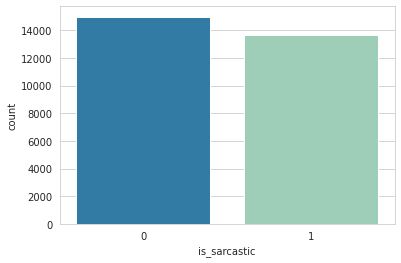

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='is_sarcastic',data=data, palette='YlGnBu_r')

- we can see that the dataset is balanced.

# **2. Retain relevant columns**

In [9]:
df = data.drop('article_link',axis=1)

In [10]:
df.head(5)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [11]:
df['headline'] = df['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

# **3. Get length of each sentence**

In [12]:
df['length'] = df['headline'].apply(lambda x:len(x.split(" ")))

In [13]:
df.head(10)

,is_sarcastic,headline,length
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep totally nails why congress is falling...,15
2,0,eat your veggies deliciously different recipes,9
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word strea...,11
5,0,my white inheritance,3
6,0,ways to file your taxes with less stress,10
7,1,richard branson s global warming donation near...,15
8,1,shadow government getting too large to meet in...,12
9,0,lots of parents know this scenario,6


# **4. Define parameters**

In [14]:
max_features = 10000
maxlen = 256
embedding_size = 50

# **5. Get indices for words**

In [15]:
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(list(df['headline']))

X = tokenizer.texts_to_sequences(df['headline']) 

print(X[0])

[352, 3155, 6257, 2143, 2, 641, 1123]


# **6. Create features and labels**

In [16]:
X = pad_sequences(X, maxlen = maxlen)   #features 

y = np.asarray(df['is_sarcastic'])    #Labels

# **7. Get vocabulary size**

In [17]:
X.shape

(28619, 256)

In [18]:
print("Number of Samples:", len(X))      
print("Number of Labels: ", len(y))     

Number of Samples: 28619
Number of Labels:  28619


In [19]:
num_words = len(tokenizer.word_index) + 1
print('vocabulary size-',num_words)

vocabulary size- 25916


# **8. Create a weight matrix using GloVe embeddings**

In [20]:
embedding_file = '/content/drive/MyDrive/Dataset/lstm/glove.6B.50d.txt'
embedding = {}

for o in open(embedding_file):
    word = o.split(" ")[0]
    embd = np.asarray(o.split(" ")[1:] , dtype = 'float32')
    embedding[word] = embd

In [21]:
embedding_matrix = np.zeros((num_words,50))

for word,i in tokenizer.word_index.items():
  if word in embedding.keys():
    embedding_matrix[i] = embedding[word]

In [22]:
len(embedding.values())

400000

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# **9. Define and compile a Bidirectional LSTM model.**

In [24]:
model_lstm = Sequential()

model_lstm.add(Embedding(num_words, embedding_size,weights = [embedding_matrix], input_length=maxlen))

model_lstm.add(Bidirectional(LSTM(16)))

model_lstm.add(Dense(16, activation='relu'))

model_lstm.add(Dropout(0.5))

model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 50)           1295800   
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                8576      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,304,921
Trainable params: 1,304,921
Non-trainable params: 0
_________________________________________________________________


# **10. Fit the model and check the validation accuracy**

In [26]:
epochs = 20
batch_size = 32
history=model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
627/627 [==============================] - 78s 112ms/step - loss: 0.5467 - accuracy: 0.7123 - val_loss: 0.3881 - val_accuracy: 0.8312
Epoch 2/20
627/627 [==============================] - 68s 108ms/step - loss: 0.3407 - accuracy: 0.8646 - val_loss: 0.3381 - val_accuracy: 0.8512
Epoch 3/20
627/627 [==============================] - 67s 107ms/step - loss: 0.2480 - accuracy: 0.9124 - val_loss: 0.3277 - val_accuracy: 0.8627
Epoch 4/20
627/627 [==============================] - 67s 107ms/step - loss: 0.1806 - accuracy: 0.9399 - val_loss: 0.3937 - val_accuracy: 0.8592
Epoch 5/20
627/627 [==============================] - 68s 108ms/step - loss: 0.1385 - accuracy: 0.9568 - val_loss: 0.4180 - val_accuracy: 0.8595
Epoch 6/20
627/627 [==============================] - 67s 107ms/step - loss: 0.1146 - accuracy: 0.9646 - val_loss: 0.5590 - val_accuracy: 0.8454
Epoch 7/20
627/627 [==============================] - 67s 107ms/step - loss: 0.0804 - accuracy: 0.9753 - val_loss: 0.5889 - val_ac

**Validation accuracy**

In [27]:
loss, acc = model_lstm.evaluate(X_test, y_test, verbose=2)
print("Overall scores")
print("Loss\t\t: ", round(loss, 3))
print("Validation Accuracy\t: ", round(acc, 3))

269/269 - 8s - loss: 1.7763 - accuracy: 0.8359
Overall scores
Loss		:  1.776
Validation Accuracy	:  0.836


In [28]:
predict=model_lstm.predict_classes(X_test)
predict_classes=predict.reshape(len(X_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,predict_classes))

print(classification_report(y_test,predict_classes))

[[3637  824]
 [ 585 3540]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4461
           1       0.81      0.86      0.83      4125

    accuracy                           0.84      8586
   macro avg       0.84      0.84      0.84      8586
weighted avg       0.84      0.84      0.84      8586



Text(0.5, 1.0, 'Training and validation loss')

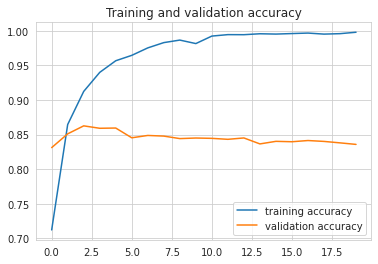

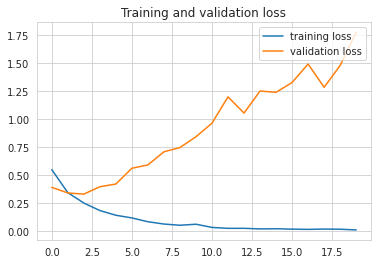

In [30]:
import matplotlib.pyplot as plt
accuracy      = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss'   )